In [1]:
import pprint
import random
import string
import time

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data.dataloader as dataloader

In [2]:
# Upload and read the csv files from the github repo
df = pd.read_csv("braille.csv")

print(df.shape)
df.head()

(1404, 2)


,Image,Label
0,cjhnk51rtqdvl07027euklbel%2F4f41b11d-d4b2-438c...,a
1,cjhnk51rtqdvl07027euklbel%2F4f41b11d-d4b2-438c...,b
2,cjhnk51rtqdvl07027euklbel%2F4f41b11d-d4b2-438c...,c
3,cjhnk51rtqdvl07027euklbel%2F4f41b11d-d4b2-438c...,d
4,cjhnk51rtqdvl07027euklbel%2F4f41b11d-d4b2-438c...,e


In [3]:
# generate the targets 
# the targets are one hot encoding vectors

# Initalize a target dict that has the letters as its keys and as its value
# an empty one-hot encoding of size 26
target = {_: [0] * 27 for _ in string.ascii_lowercase}

# Do the one-hot encoding for each letter now 
for letter in target.keys():
    target[letter][ord(letter) - 97] = 1

# add a space as a "letter" in target
target[' '] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [4]:
printer = pprint.PrettyPrinter(indent=2, depth=2, compact=True, width=90)
printer.pprint(target)

{ ' ': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  'a': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'b': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'c': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'd': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'e': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'f': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'g': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'h': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'i': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'j': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'k': [0,

In [5]:
# collect all data from the csv file
def read_data(df: pd.DataFrame):
    data: list[tuple[torch.Tensor , torch.LongTensor]]=[]

# iterate over csv file
    for i, row in df.iterrows():
        filename = row['Image']
        label = row['Label']
        curr_target = target[label]

        image = cv.imread(f"data/{filename}", cv.IMREAD_COLOR)
        # resize image to 28x28x3
        image = cv.resize(image, (28, 28))
        # normalize to 0-1
        image = image.astype(np.float32)/255.0
        image = torch.from_numpy(image)

        # convert the target to a long tensor
        curr_target=torch.LongTensor([curr_target])
    
        # append the current image & target
        data.append((image, curr_target))
    
    return data

In [6]:
data = read_data(df)
random.shuffle(data)
len(data)

1404

In [7]:
# batch sizes for train, test, and validation
batch_train = 20
batch_test = 5
batch_validation = 5

# splitting data to get training, test, and validation sets
# currently splitting my csv file only
# has 1404 in total
# 140 each for test and train
# 1124 for train
train_data = data[:1124]
# test has 164
test_data = data[1124:1264]
# validation has 164
validation_data = data[1264:]

In [8]:
# create the dataloader objects
train_loader = dataloader.DataLoader(dataset=train_data, batch_size=batch_train, shuffle=True)
test_loader = dataloader.DataLoader(dataset=test_data, batch_size=batch_test, shuffle=False)
validation_loader = dataloader.DataLoader(dataset=validation_data, batch_size=batch_validation, shuffle=True)

In [9]:
# defines the convolutional neural network
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.cnn = nn.Sequential(
            self._block(3, 16, kernel_size=5, stride=1, padding=2),
            self._block(16, 32, kernel_size=5, stride=1, padding=2),
        )

        # Linear Layer: Input Dimension --> 32x7x7
        self.flat = nn.Sequential(
            nn.Linear(32*7*7, 100),
            # Output Dimension --> 1x100
            nn.LeakyReLU(),

            nn.Linear(100, 27),
            # Output Dimension --> 1x27
            # nn.Sigmoid()
        )
            
    def _block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU()
        )
    
    def forward(self, x): 
        out = self.cnn(x)

        # flatten the dataset
        flattened = self.flat(out.reshape(-1, 32*7*7))
        
        return flattened

In [10]:
# convolutional neural network model
model = CNN()

# print summary of the neural network model to check if everything is fine. 
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

CNN(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (flat): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=27, bias=True)
  )
)
# parameter:  173627
Model's state_dict:
cnn.0.0.weight 	 torch.Size([16, 3, 5, 5])
cnn.1.0.weight 	 torch.Size([32, 16, 5, 5])
flat.0.weight 	 torch.Size([100, 1568])
flat.0.bias 	 torch.Size([100])
flat.2.

In [11]:
# setting the learning rate
learning_rate = 1e-3

# Using a variable to store the cross entropy method
criterion = nn.CrossEntropyLoss()

# Using a variable to store the optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

# list of all train_losses in 30 epochs
train_losses = []
# list of all validation losses in 30 epochs
validation_losses = []

# total train losses
total_train_loss = []
# total validation losses
total_validation_loss = []

In [12]:
# for loop that iterates over all the epochs
num_epochs = 20

t0 = time.time()
for epoch in range(num_epochs):
    
    # variables to store/keep track of the loss and number of iterations
    train_loss = 0
    num_iter_train = 0

    # train the model
    model.train()
    
    # Iterate over train_loader
    for i, (images, labels) in enumerate(train_loader):  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Zero the gradient buffer
        # resets the gradient after each epoch so that the gradients don't add up
        optimizer.zero_grad()  

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors into integer values 
        labels = labels.view(-1, 27)
        y_true = torch.argmax(labels, 1)

        loss = criterion(outputs, y_true)

        #print('loss:', loss)
        total_train_loss.append(loss)
        # Backward (computes all the gradients)
        loss.backward()

        # Optimize
        # loops through all parameters and updates weights by using the gradients 
        # takes steps backwards to optimize (to reach the minimum weight)
        optimizer.step()
        # update the training loss and number of iterations
        train_loss += loss.item()
        num_iter_train += 1

    print(f"Epoch: {epoch+1}")
    print(f"Training Loss: {train_loss/num_iter_train:.4f}")
    # append the train_losses over all the epochs
    train_losses.append(train_loss/num_iter_train)
    
    # variables to store/keep track of the loss and number of iterations
    validation_loss = 0
    num_iter_validation = 0
    
    # Iterate over train_loader
    for i, (images, labels) in enumerate(validation_loader):  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)
        # print(images.shape)

        # Zero the gradient buffer
        # resets the gradient after each epoch so that the gradients don't add up
        optimizer.zero_grad()  

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors to integer values
        labels = labels.view(-1, 27)
        y_true = torch.argmax(labels, 1)
        # calculate the loss
        loss = criterion(outputs, y_true)
        #print('loss:', loss)
        total_validation_loss.append(loss)

        # update the training loss and number of iterations
        validation_loss += loss.item()
        num_iter_validation += 1

    print(f"Validation Loss: {validation_loss/num_iter_validation:.4f}")
    # append all validation_losses over all the epochs
    validation_losses.append(validation_loss/num_iter_validation)
    
    # evaluate the model
    model.eval()

    correct = 0
    total = 0
    num_iter_test = 0
    mean = 0
    
    # Iterate over test_loader
    for images, labels in test_loader:  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors into integer values 
        labels = labels.view(-1, 27)
        y_true = torch.argmax(labels, 1)

        # find the index of the prediction
        y_pred = torch.argmax(outputs, 1).type('torch.FloatTensor')
        # convert to FloatTensor
        y_true = y_true.type('torch.FloatTensor')

        # find the mean difference of the comparisons
        mean += torch.mean(torch.eq(y_true, y_pred).type('torch.FloatTensor'))  

    print(f"Accuracy on the test set: {mean/len(test_loader) * 100:.4f}%")

tf = time.time()

Epoch: 1
Training Loss: 3.3019
Validation Loss: 3.2918
Accuracy on the test set: 7.1429%
Epoch: 2
Training Loss: 3.2955
Validation Loss: 3.2707
Accuracy on the test set: 9.2857%
Epoch: 3
Training Loss: 2.7656
Validation Loss: 1.8275
Accuracy on the test set: 47.8571%
Epoch: 4
Training Loss: 1.0461
Validation Loss: 0.7122
Accuracy on the test set: 80.0000%
Epoch: 5
Training Loss: 0.4909
Validation Loss: 0.4551
Accuracy on the test set: 89.2857%
Epoch: 6
Training Loss: 0.3210
Validation Loss: 0.4299
Accuracy on the test set: 90.7143%
Epoch: 7
Training Loss: 0.2440
Validation Loss: 0.4142
Accuracy on the test set: 92.1429%
Epoch: 8
Training Loss: 0.2247
Validation Loss: 0.4236
Accuracy on the test set: 91.4286%
Epoch: 9
Training Loss: 0.1600
Validation Loss: 0.2661
Accuracy on the test set: 90.7143%
Epoch: 10
Training Loss: 0.1396
Validation Loss: 0.3363
Accuracy on the test set: 92.1429%
Epoch: 11
Training Loss: 0.1044
Validation Loss: 0.2709
Accuracy on the test set: 92.1428%
Epoch: 12


In [13]:
# calculate time it took to train the model
print()
print(f"time: {tf-t0} s")


time: 31.285205602645874 s


In [14]:
# learning curve function
def plot_learning_curve(train_losses, validation_losses):
    # plot the training and validation losses
    # x-axis is the number of training steps
    # y-axis is loss
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.plot(train_losses, label="training")
    plt.plot(validation_losses, label="validation")
    plt.legend(loc=1)

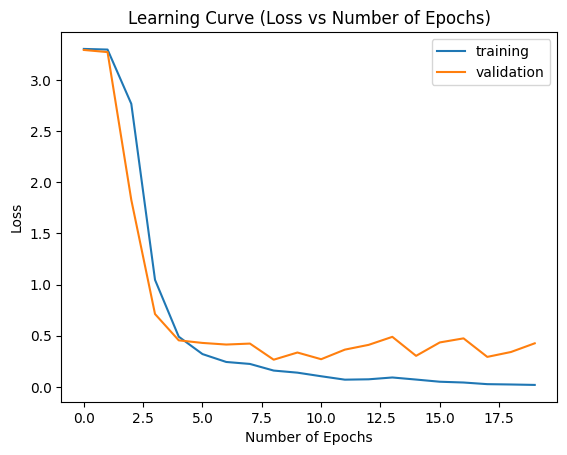

In [15]:
# plot the learning curve
plt.title("Learning Curve (Loss vs Number of Epochs)")
plot_learning_curve(train_losses, validation_losses)

In [16]:
torch.save(model.state_dict(), 'ascii.pth')

In [17]:
cnn = CNN()
cnn.load_state_dict(torch.load('ascii.pth'))
cnn.eval()

CNN(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (flat): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=27, bias=True)
  )
)

In [25]:
filename = f"cjhnk51rtqdvl07027euklbel%2F4f41b11d-d4b2-438c-9d4f-4950d65f9513%2Fa.jpg"

image = cv.imread(f"data/{filename}", cv.IMREAD_COLOR)
print(f"Read image shape: {image.shape}")
# resize image to 28x28x3
image = cv.resize(image, (28, 28))
print(f"Image shape after resize: {image.shape}")
# normalize to 0-1
image = image.astype(np.float32)/255.0
image = torch.from_numpy(image)

print(f"Tensor shape: {image.shape}")

Read image shape: (175, 120, 3)
Image shape after resize: (28, 28, 3)
Tensor shape: torch.Size([28, 28, 3])


In [24]:
# output = model(image)

RuntimeError: Given groups=1, weight of size [16, 3, 5, 5], expected input[1, 28, 28, 3] to have 3 channels, but got 28 channels instead